In [4]:
import pandas as pd

# Carga el CSV
df = pd.read_csv("solana_5000h_coingecko.csv")

# Muestra las primeras filas
print(df.head())


             timestamp        open        high         low       close  \
0  2025-06-10 06:00:00  158.123005  158.123005  158.123005  158.123005   
1  2025-06-10 07:00:00  158.317370  158.317370  158.317370  158.317370   
2  2025-06-10 08:00:00  158.431356  158.431356  158.431356  158.431356   
3  2025-06-10 09:00:00  158.140291  158.140291  158.140291  158.140291   
4  2025-06-10 10:00:00  158.833437  158.833437  158.833437  158.833437   

         volume  
0  8.566360e+09  
1  8.602750e+09  
2  8.697987e+09  
3  8.718309e+09  
4  8.458221e+09  


In [3]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta

BASE_URL = "https://api.coingecko.com/api/v3/coins/solana/market_chart"
VS_CURRENCY = "usd"

TOTAL_HOURS = 5000
HOURS_PER_DAY = 24
TOTAL_DAYS = TOTAL_HOURS / HOURS_PER_DAY  # ≈208 días
BLOCK_DAYS = 90  # CoinGecko limita a 90 días por request
SLEEP_SECONDS = 5  # pausa entre requests para no superar rate limit

all_prices = []
all_volumes = []

days_remaining = TOTAL_DAYS
while days_remaining > 0:
    days_to_fetch = min(BLOCK_DAYS, days_remaining)
    print(f"🚀 Descargando bloque de {days_to_fetch:.1f} días...")

    params = {
        "vs_currency": VS_CURRENCY,
        "days": days_to_fetch
    }

    try:
        response = requests.get(BASE_URL, params=params)
        if response.status_code != 200:
            print(f"❌ Error: {response.status_code}, {response.text}")
            break

        data = response.json()
        all_prices.extend(data['prices'])
        all_volumes.extend(data['total_volumes'])

    except Exception as e:
        print(f"❌ Error en request: {e}")
        break

    days_remaining -= days_to_fetch
    time.sleep(SLEEP_SECONDS)

# Crear DataFrame
df = pd.DataFrame(all_prices, columns=['timestamp','price'])
df['volume'] = [v[1] for v in all_volumes]
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Resample a 1h
df_ohlc = df.resample('1h', on='timestamp').agg({
    'price': ['first','max','min','last'],
    'volume': 'sum'
})
df_ohlc.columns = ['open','high','low','close','volume']
df_ohlc.reset_index(inplace=True)

# Guardar CSV
df_ohlc.to_csv("solana_5000h_coingecko.csv", index=False)
print(f"✅ Dataset guardado con {len(df_ohlc)} filas (≈{len(df_ohlc)} horas)")



🚀 Descargando bloque de 90.0 días...


🚀 Descargando bloque de 90.0 días...
🚀 Descargando bloque de 28.3 días...
✅ Dataset guardado con 2160 filas (≈2160 horas)


In [5]:
# Mantener solo timestamps entre 2010 y 2035
df = df[(df['open_time'] > 1262304000000) & (df['open_time'] < 2051222400000)]

# Convertir a datetime
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms', errors='coerce')
df["close_time"] = pd.to_datetime(df["close_time"], unit='ms', errors='coerce')

# Quitar filas inválidas
df = df.dropna(subset=["open_time", "close_time"]).reset_index(drop=True)

df.head()


,open_time,open,high,low,close,volume,close_time,quote_volume,num_trades,taker_base_volume,taker_quote_volume,ignore
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17 23:59:59.999,3.454770e+06,3427,616.248541,2.678216e+06,8733.911395
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18 23:59:59.999,5.086958e+06,5233,972.868710,4.129123e+06,9384.141409
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19 23:59:59.999,1.549484e+06,2153,274.336042,1.118002e+06,9184.085529
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20 23:59:59.999,1.930364e+06,2321,376.795947,1.557401e+06,10125.414084
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21 23:59:59.999,2.797232e+06,3972,557.356107,2.255663e+06,11706.769970


In [6]:
#Información general del dataset:

df.info()
df.describe()


#Comprobar valores nulos:

df.isnull().sum()


#Resumen básico:

print(f"Fechas: {df['open_time'].min()} -> {df['open_time'].max()}")
print(f"Número de registros: {len(df)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   open_time           2694 non-null   datetime64[ns]
 1   open                2694 non-null   float64       
 2   high                2694 non-null   float64       
 3   low                 2694 non-null   float64       
 4   close               2694 non-null   float64       
 5   volume              2694 non-null   float64       
 6   close_time          2694 non-null   datetime64[ns]
 7   quote_volume        2694 non-null   float64       
 8   num_trades          2694 non-null   int64         
 9   taker_base_volume   2694 non-null   float64       
 10  taker_quote_volume  2694 non-null   float64       
 11  ignore              2694 non-null   float64       
dtypes: datetime64[ns](2), float64(9), int64(1)
memory usage: 252.7 KB
Fechas: 2017-08-17 00:00:00 -> 2024-12

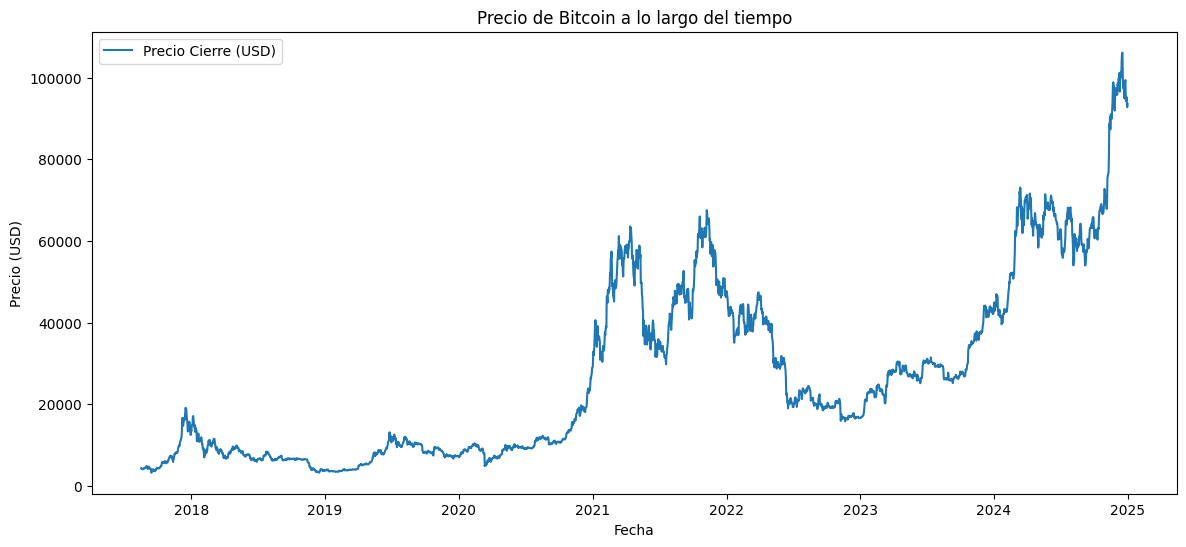

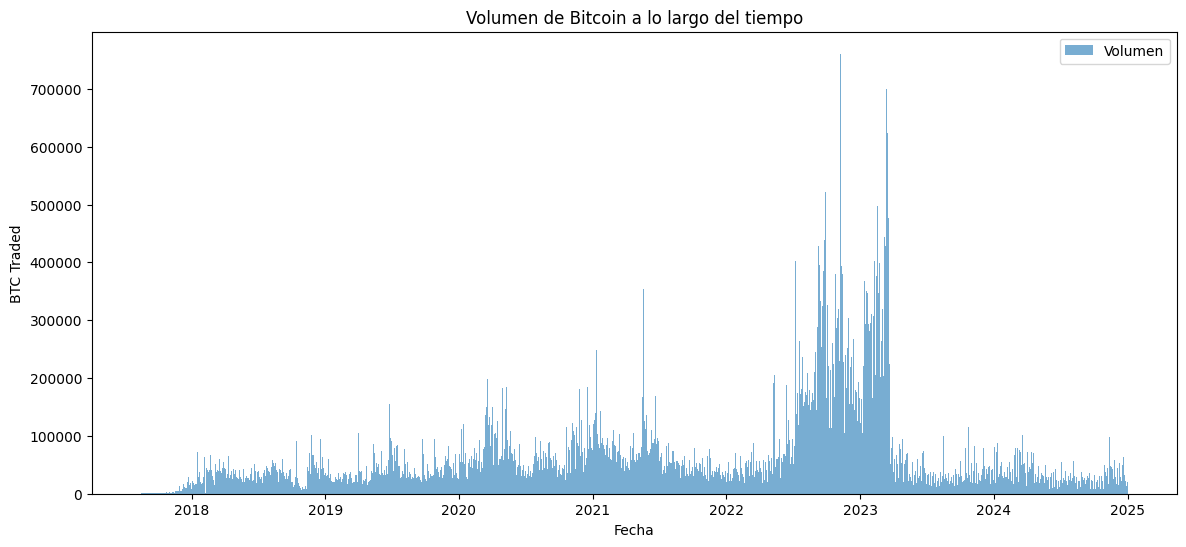

In [7]:
#Gráfico de precios:

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df["open_time"], df["close"], label="Precio Cierre (USD)")
plt.title("Precio de Bitcoin a lo largo del tiempo")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.legend()
plt.show()


#Gráfico de volumen:

plt.figure(figsize=(14,6))
plt.bar(df["open_time"], df["volume"], width=1, label="Volumen", alpha=0.6)
plt.title("Volumen de Bitcoin a lo largo del tiempo")
plt.xlabel("Fecha")
plt.ylabel("BTC Traded")
plt.legend()
plt.show()

In [8]:
import pandas as pd
import numpy as np

# === 1. Medias móviles ===
df["SMA_20"] = df["close"].rolling(window=20).mean()  # Media móvil simple de 20 días
df["SMA_50"] = df["close"].rolling(window=50).mean()  # Media móvil simple de 50 días
df["EMA_20"] = df["close"].ewm(span=20, adjust=False).mean()  # Media móvil exponencial de 20 días

# === 2. Retornos diarios ===
df["daily_return"] = df["close"].pct_change() * 100  # % de cambio diario

# === 3. Volatilidad histórica (rolling std) ===
df["volatility_20d"] = df["daily_return"].rolling(window=20).std()  # desviación estándar 20 días

# === 4. RSI (Relative Strength Index) ===
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["RSI_14"] = compute_rsi(df["close"], period=14)

# === 5. Tendencia simple (basada en cruce de medias móviles) ===
df["trend"] = np.where(df["SMA_20"] > df["SMA_50"], "Alcista", "Bajista")

# Mostrar últimas filas
print(df.tail(10))


      open_time      open      high       low     close       volume  \
2684 2024-12-22  97292.00  97448.08  94250.35  95186.27  19353.83036   
2685 2024-12-23  95186.28  96538.92  92520.00  94881.47  32810.76703   
2686 2024-12-24  94881.47  99487.99  93569.02  98663.58  23674.22488   
2687 2024-12-25  98663.58  99569.15  97632.02  99429.60  14474.16510   
2688 2024-12-26  99429.61  99963.70  95199.14  95791.60  21192.36727   
2689 2024-12-27  95791.60  97544.58  93500.01  94299.03  26501.26429   
2690 2024-12-28  94299.03  95733.99  94135.66  95300.00   8385.89290   
2691 2024-12-29  95300.00  95340.00  93009.52  93738.20  13576.00578   
2692 2024-12-30  93738.19  95024.50  91530.45  92792.05  27619.42250   
2693 2024-12-31  92792.05  96250.00  92033.73  93576.00  19612.03389   

                  close_time  quote_volume  num_trades  taker_base_volume  \
2684 2024-12-22 23:59:59.999  1.857820e+09     3633551         9293.39749   
2685 2024-12-23 23:59:59.999  3.100007e+09     546491

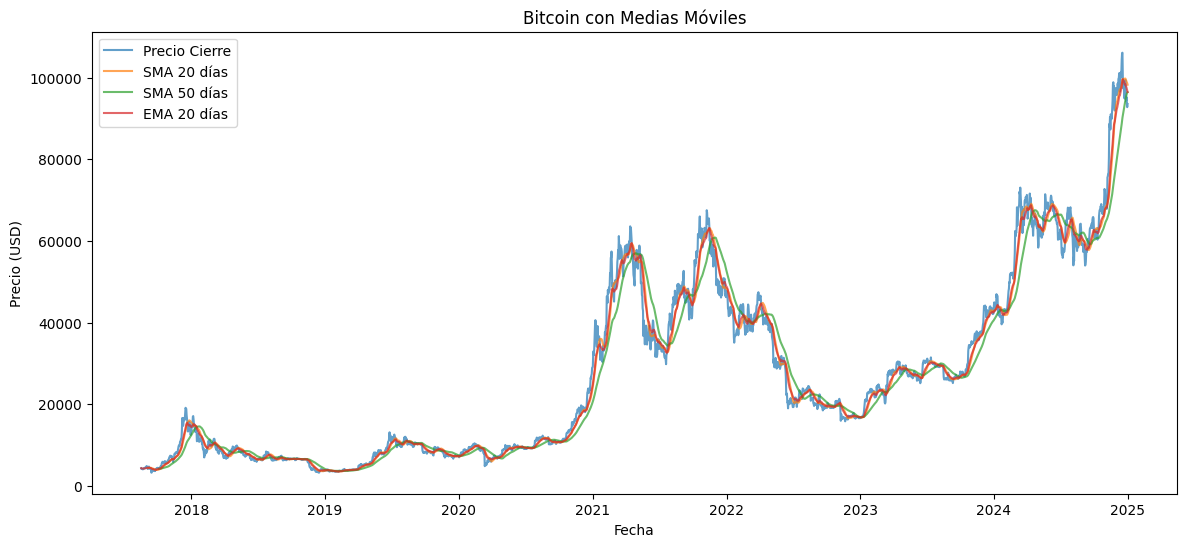

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df["open_time"], df["close"], label="Precio Cierre", alpha=0.7)
plt.plot(df["open_time"], df["SMA_20"], label="SMA 20 días", alpha=0.7)
plt.plot(df["open_time"], df["SMA_50"], label="SMA 50 días", alpha=0.7)
plt.plot(df["open_time"], df["EMA_20"], label="EMA 20 días", alpha=0.7)
plt.title("Bitcoin con Medias Móviles")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.legend()
plt.show()


In [32]:
import pandas as pd

# Carga el CSV
df = pd.read_csv("SOLUSDT_1d_full.csv")

# Muestra las primeras filas
print(df.tail())

       Open Time    Open    High     Low   Close       Volume  \
1599  2024-12-27  188.46  194.39  182.74  184.22  1946509.645   
1600  2024-12-28  184.22  196.10  183.82  195.50  1494847.867   
1601  2024-12-29  195.50  197.71  188.57  189.94  1560190.019   
1602  2024-12-30  189.94  196.47  185.89  191.38  2415985.488   
1603  2024-12-31  191.37  199.27  188.04  189.31  2461978.262   

                   Close Time  Quote Asset Volume  Number of Trades  \
1599  2024-12-27 23:59:59.999        3.664021e+08           1296546   
1600  2024-12-28 23:59:59.999        2.837252e+08            840578   
1601  2024-12-29 23:59:59.999        3.025510e+08            861977   
1602  2024-12-30 23:59:59.999        4.623926e+08           1417191   
1603  2024-12-31 23:59:59.999        4.764511e+08           1249847   

      Taker Buy Base Asset Volume  Taker Buy Quote Asset Volume  Ignore  
1599                   991253.947                  1.865689e+08       0  
1600                   782994.954 

In [22]:
import pandas as pd

# Cargar el dataset completo
full_df = pd.read_csv("SOLUSDT_1d_full.csv")

# Convertir la columna de fechas a datetime
full_df["Open Time"] = pd.to_datetime(full_df["Open Time"])
full_df["Close Time"] = pd.to_datetime(full_df["Close Time"])



In [23]:
# Medias móviles
full_df['MA7'] = full_df['Close'].rolling(7).mean()
full_df['MA21'] = full_df['Close'].rolling(21).mean()

# Retornos diarios
full_df['Return'] = full_df['Close'].pct_change()

# Precios rezagados (lags)
full_df['Close_lag1'] = full_df['Close'].shift(1)
full_df['Close_lag2'] = full_df['Close'].shift(2)


In [24]:
#Eliminar filas con valores nulos (porque los indicadores y lags generan NaN al inicio):

full_df = full_df.dropna()

In [25]:
#Definir variables de entrenamiento y target:

# Features
X = full_df[['Open', 'High', 'Low', 'Volume', 'MA7', 'MA21', 'Return', 'Close_lag1', 'Close_lag2']]

# Target (precio de cierre del día siguiente)
y = full_df['Close'].shift(-1)  # desplazamos una fila hacia arriba
X = X[:-1]  # eliminamos la última fila sin target
y = y[:-1]

In [26]:
import pandas as pd

# 1. Cargar el dataset (ajusta el nombre si es diferente)
full_df = pd.read_csv("SOLUSDT_1d_full.csv")

# 2. Convertir las fechas
full_df["Open Time"] = pd.to_datetime(full_df["Open Time"])
full_df["Close Time"] = pd.to_datetime(full_df["Close Time"])

# 3. Crear features
full_df['MA7'] = full_df['Close'].rolling(7).mean()
full_df['MA21'] = full_df['Close'].rolling(21).mean()
full_df['Return'] = full_df['Close'].pct_change()
full_df['Close_lag1'] = full_df['Close'].shift(1)
full_df['Close_lag2'] = full_df['Close'].shift(2)

# 4. Limpiar valores nulos
full_df = full_df.dropna()

# 5. Definir variables X (features) y y (target)
X = full_df[['Open', 'High', 'Low', 'Volume', 'MA7', 'MA21', 'Return', 'Close_lag1', 'Close_lag2']]
y = full_df['Close'].shift(-1)  # Queremos predecir el precio del siguiente día

# Eliminar la última fila porque no tiene target
X = X[:-1]
y = y[:-1]

# 6. Dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



(1266, 9) (317, 9) (1266,) (317,)


In [27]:
from sklearn.ensemble import RandomForestRegressor

# Crear el modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar
model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test)



In [28]:
#Evaluar el modelo (Métricas de error)
#Vamos a calcular MAE, RMSE y R² para ver qué tan bien predice:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 MAE: {mae:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 R²: {r2:.4f}")

📊 MAE: 6.5063
📊 RMSE: 8.1859
📊 R²: 0.9349


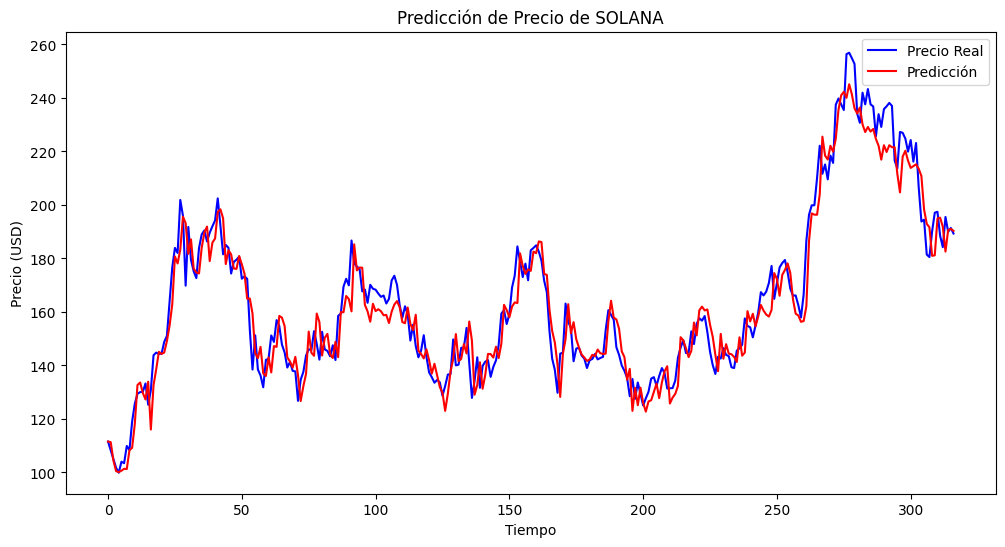

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Precio Real", color='blue')
plt.plot(y_pred, label="Predicción", color='red')
plt.title("Predicción de Precio de SOLANA")
plt.xlabel("Tiempo")
plt.ylabel("Precio (USD)")
plt.legend()
plt.show()


In [33]:
import pandas as pd
import numpy as np

# Vamos a usar las últimas filas para simular una predicción
ultimos_datos = X.tail(30)  # Cambia 7 por el número de días que quieras predecir
predicciones_futuras = model.predict(ultimos_datos)

# Mostrar predicciones
fechas_futuras = pd.date_range(start=full_df["Open Time"].iloc[-1], periods=31, freq='D')[1:]
pred_df = pd.DataFrame({"Fecha": fechas_futuras, "Predicción Precio SOL": predicciones_futuras})

print(pred_df)


        Fecha  Predicción Precio SOL
0  2025-01-01               224.6506
1  2025-01-02               222.1239
2  2025-01-03               216.9340
3  2025-01-04               222.3198
4  2025-01-05               219.7884
5  2025-01-06               222.3418
6  2025-01-07               221.5718
7  2025-01-08               221.5803
8  2025-01-09               211.6265
9  2025-01-10               204.6784
10 2025-01-11               218.0708
11 2025-01-12               220.2496
12 2025-01-13               216.5529
13 2025-01-14               213.8416
14 2025-01-15               214.4913
15 2025-01-16               215.1818
16 2025-01-17               213.5102
17 2025-01-18               210.8101
18 2025-01-19               198.2871
19 2025-01-20               192.9414
20 2025-01-21               191.6351
21 2025-01-22               180.9819
22 2025-01-23               181.1767
23 2025-01-24               194.9162
24 2025-01-25               195.2361
25 2025-01-26               191.8778
2

📊 MAE: 6.8652
📈 R² Score: 0.9277


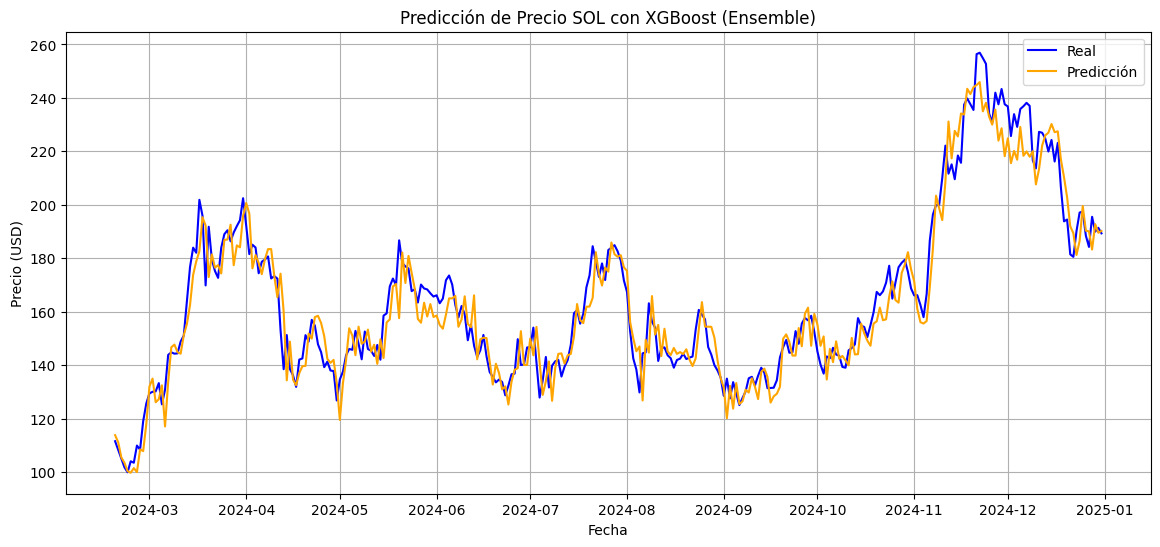

        Fecha  Predicción Precio SOL
0  2025-01-01             212.568771
1  2025-01-02             219.454651
2  2025-01-03             211.517349
3  2025-01-04             227.240753
4  2025-01-05             212.601303
5  2025-01-06             215.768723
6  2025-01-07             213.061264
7  2025-01-08             215.472824
8  2025-01-09             210.812714
9  2025-01-10             212.167084
10 2025-01-11             223.193466
11 2025-01-12             226.665314
12 2025-01-13             227.774414
13 2025-01-14             230.915985
14 2025-01-15             227.401611
15 2025-01-16             228.497894
16 2025-01-17             218.195755
17 2025-01-18             210.274948
18 2025-01-19             199.650650
19 2025-01-20             194.296707
20 2025-01-21             190.919281
21 2025-01-22             181.446198
22 2025-01-23             188.167801
23 2025-01-24             201.124542
24 2025-01-25             190.495865
25 2025-01-26             191.194077
2

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# ===============================
# 1. CARGAR Y PREPARAR LOS DATOS
# ===============================
# Carga tu dataset (ajusta el nombre si es necesario)
df = pd.read_csv("SOLUSDT_1d_full.csv")

# Convertir fechas
df["Open Time"] = pd.to_datetime(df["Open Time"])
df["Close Time"] = pd.to_datetime(df["Close Time"])

# Crear features
df['MA7'] = df['Close'].rolling(7).mean()
df['MA21'] = df['Close'].rolling(21).mean()
df['Return'] = df['Close'].pct_change()
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)

# Limpiar valores nulos
df = df.dropna()

# Variables de entrada (X) y salida (y)
X = df[['Open', 'High', 'Low', 'Volume', 'MA7', 'MA21', 'Return', 'Close_lag1', 'Close_lag2']]
y = df['Close'].shift(-1)
X = X[:-1]
y = y[:-1]

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ===============================
# 2. ENTRENAR MODELOS
# ===============================
# Modelo A
m1 = XGBRegressor(
    n_estimators=600, 
    learning_rate=0.03, 
    max_depth=5, 
    random_state=42, 
    verbosity=0
)
m1.fit(X_train, y_train, verbose=0)

# Modelo B
m2 = XGBRegressor(
    n_estimators=400, 
    learning_rate=0.05, 
    max_depth=3, 
    random_state=7, 
    verbosity=0
)
m2.fit(X_train, y_train, verbose=0)

# ===============================
# 3. PREDICCIONES Y EVALUACIÓN
# ===============================
pred1 = m1.predict(X_test)
pred2 = m2.predict(X_test)

# Ensemble (promedio de ambos)
pred_final = (pred1 + pred2) / 2

mae = mean_absolute_error(y_test, pred_final)
r2 = r2_score(y_test, pred_final)

print(f"📊 MAE: {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# ===============================
# 4. VISUALIZACIÓN
# ===============================
plt.figure(figsize=(14,6))
plt.plot(df["Open Time"].iloc[-len(y_test):], y_test, label="Real", color="blue")
plt.plot(df["Open Time"].iloc[-len(y_test):], pred_final, label="Predicción", color="orange")
plt.legend()
plt.title("Predicción de Precio SOL con XGBoost (Ensemble)")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.grid()
plt.show()

# ===============================
# 5. PREDICCIÓN FUTURA
# ===============================
ultimos_datos = X.tail(30)
predicciones_futuras = m1.predict(ultimos_datos)
fechas_futuras = pd.date_range(start=df["Open Time"].iloc[-1], periods=31, freq='D')[1:]
pred_df = pd.DataFrame({"Fecha": fechas_futuras, "Predicción Precio SOL": predicciones_futuras})

print(pred_df)


📊 MAE: 6.8652
📈 R² Score: 0.9277


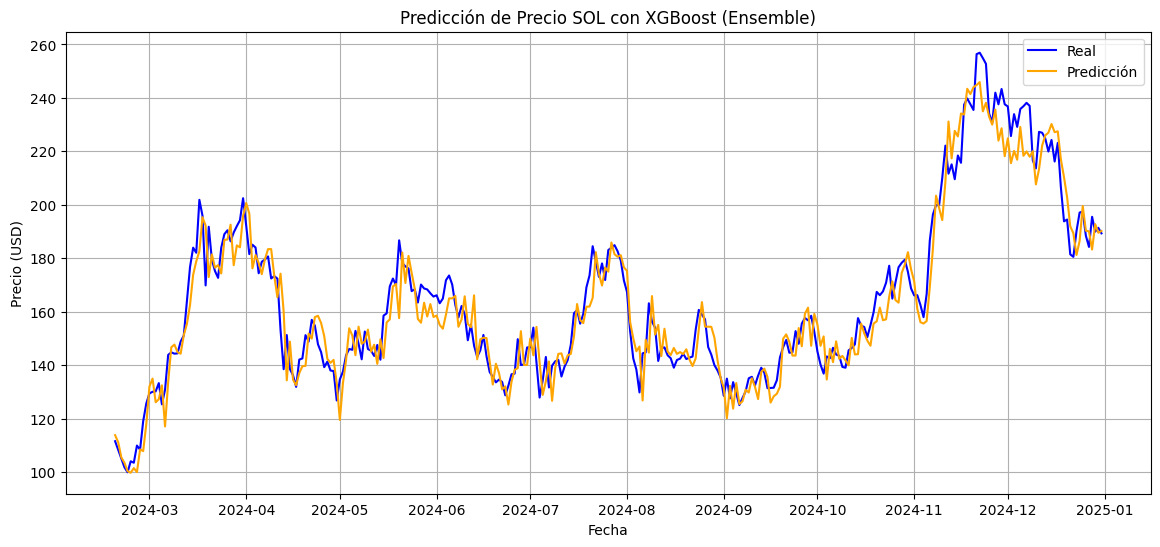

        Fecha  Predicción Precio SOL
0  2025-01-01             212.568771
1  2025-01-02             219.454651
2  2025-01-03             211.517349
3  2025-01-04             227.240753
4  2025-01-05             212.601303
5  2025-01-06             215.768723
6  2025-01-07             213.061264
7  2025-01-08             215.472824
8  2025-01-09             210.812714
9  2025-01-10             212.167084
10 2025-01-11             223.193466
11 2025-01-12             226.665314
12 2025-01-13             227.774414
13 2025-01-14             230.915985
14 2025-01-15             227.401611
15 2025-01-16             228.497894
16 2025-01-17             218.195755
17 2025-01-18             210.274948
18 2025-01-19             199.650650
19 2025-01-20             194.296707
20 2025-01-21             190.919281
21 2025-01-22             181.446198
22 2025-01-23             188.167801
23 2025-01-24             201.124542
24 2025-01-25             190.495865
25 2025-01-26             191.194077
2

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# ===============================
# 1. CARGAR Y PREPARAR LOS DATOS
# ===============================
df = pd.read_csv("SOLUSDT_1d_full.csv")
df["Open Time"] = pd.to_datetime(df["Open Time"])
df["Close Time"] = pd.to_datetime(df["Close Time"])

df['MA7'] = df['Close'].rolling(7).mean()
df['MA21'] = df['Close'].rolling(21).mean()
df['Return'] = df['Close'].pct_change()
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)

df = df.dropna()

X = df[['Open', 'High', 'Low', 'Volume', 'MA7', 'MA21', 'Return', 'Close_lag1', 'Close_lag2']]
y = df['Close'].shift(-1)
X = X[:-1]
y = y[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ===============================
# 2. ENTRENAR MODELOS
# ===============================
m1 = XGBRegressor(n_estimators=600, learning_rate=0.03, max_depth=5, random_state=42, verbosity=0)
m1.fit(X_train, y_train, verbose=0)

m2 = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=3, random_state=7, verbosity=0)
m2.fit(X_train, y_train, verbose=0)

# ===============================
# 3. PREDICCIONES Y EVALUACIÓN
# ===============================
pred1 = m1.predict(X_test)
pred2 = m2.predict(X_test)

pred_final = (pred1 + pred2) / 2

mae = mean_absolute_error(y_test, pred_final)
r2 = r2_score(y_test, pred_final)

print(f"📊 MAE: {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# ===============================
# 4. VISUALIZACIÓN
# ===============================
plt.figure(figsize=(14,6))
plt.plot(df["Open Time"].iloc[-len(y_test):], y_test, label="Real", color="blue")
plt.plot(df["Open Time"].iloc[-len(y_test):], pred_final, label="Predicción", color="orange")
plt.legend()
plt.title("Predicción de Precio SOL con XGBoost (Ensemble)")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.grid()
plt.show()

# ===============================
# 5. PREDICCIÓN FUTURA
# ===============================
ultimos_datos = X.tail(30)
predicciones_futuras = m1.predict(ultimos_datos)
fechas_futuras = pd.date_range(start=df["Open Time"].iloc[-1], periods=31, freq='D')[1:]
pred_df = pd.DataFrame({"Fecha": fechas_futuras, "Predicción Precio SOL": predicciones_futuras})

print(pred_df)



In [ ]:
#Prophet
from prophet import Prophet
# Preparar dataset
df_prophet = full_df[['Open Time', 'Close']].rename(columns={"Open Time": "ds", "Close": "y"})

# Asegúrate de que las fechas estén en datetime
df_prophet['ds'] = pd.to_dimport pandas as pd

atetime(df_prophet['ds'])

In [27]:
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)


20:15:54 - cmdstanpy - INFO - Chain [1] start processing
20:15:55 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
#obtener predicciones futuras
future = model.make_future_dataframe(periods=30)  # 30 días hacia adelante
forecast = model.predict(future)


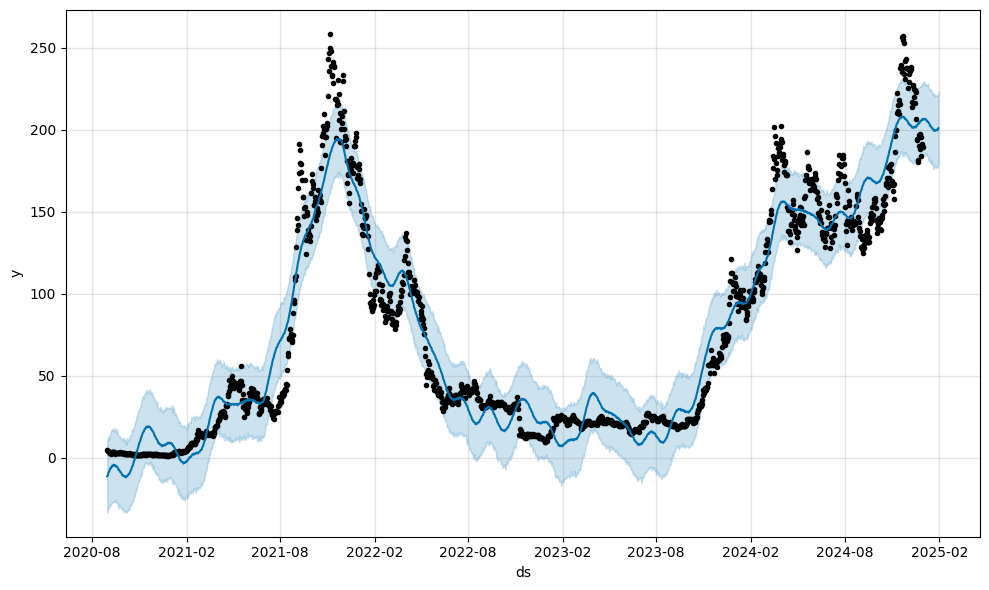

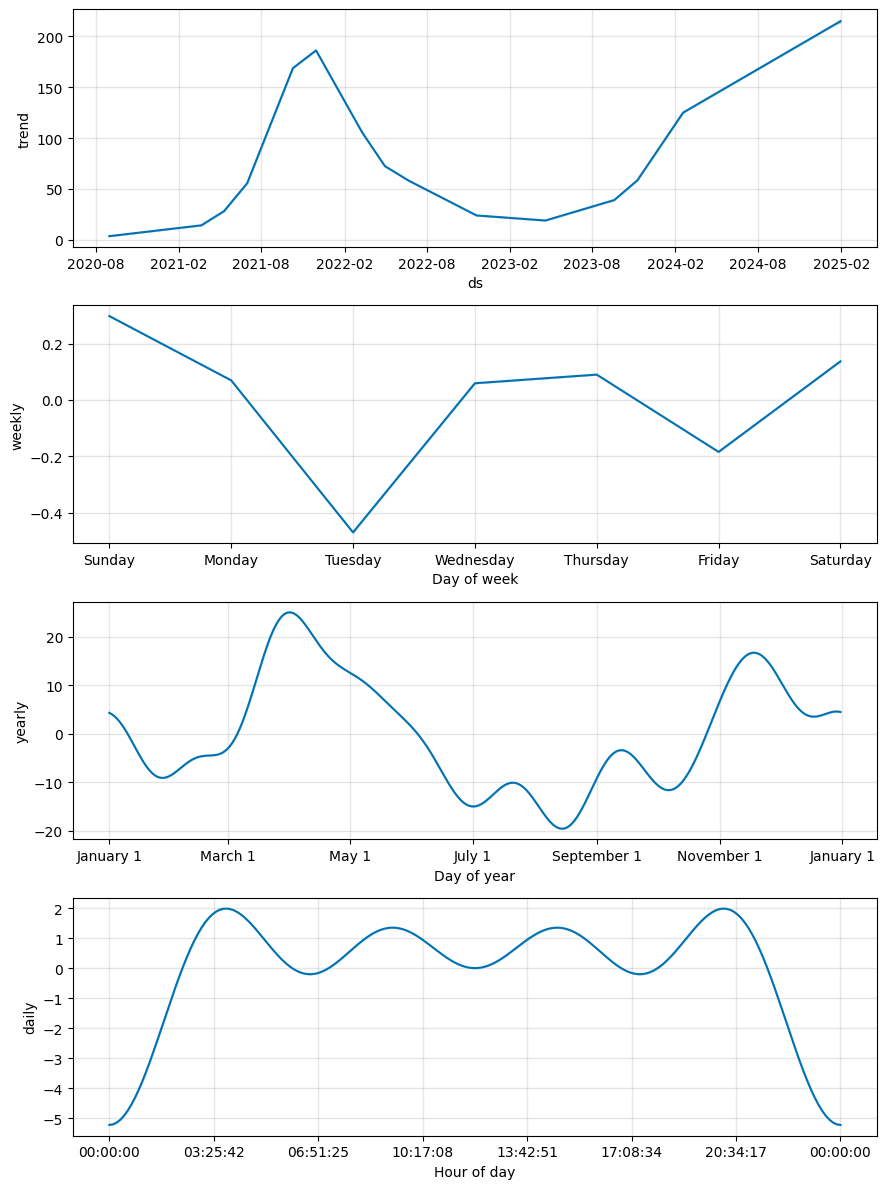

In [30]:
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

# Plot predicción completa
model.plot(forecast)
plt.show()

# Plot de componentes (tendencia, estacionalidad)
model.plot_components(forecast)
plt.show()
#Gráfica principal: model.plot(forecast)

#Esta es la gráfica de predicciones completas:

#Eje X → tiempo (fechas)

#Eje Y → precio pronosticado (y)

#Línea azul → valores pronosticados (yhat)

#Banda azul clara → intervalo de confianza del 95% (yhat_lower y yhat_upper)

#Puntos negros → valores históricos del dataset (y)

# Interpretación:

#La línea azul sigue la tendencia que Prophet estima basada en tus datos históricos.

#La banda azul clara muestra la incertidumbre: si el precio futuro se mantiene dentro de esa banda, la predicción se considera plausible.

#Esta gráfica te permite ver si el modelo captura bien la tendencia general y la volatilidad de Solana.

In [29]:
import datetime

# Fecha de hoy
hoy = pd.to_datetime("today").normalize()

# Filtrar forecast para fechas desde hoy en adelante
predicciones_futuras = forecast[forecast['ds'] >= hoy][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(predicciones_futuras)


Empty DataFrame
Columns: [ds, yhat, yhat_lower, yhat_upper]
Index: []


In [31]:
import pandas as pd
from prophet import Prophet

# Preparar dataset
df_prophet = full_df[['Open Time', 'Close']].rename(columns={"Open Time": "ds", "Close": "y"})

# Asegúrate de que las fechas estén en datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Crear y entrenar el modelo
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

# Crear dataframe futuro de 30 días
future = model.make_future_dataframe(periods=30)  # 30 días hacia adelante
forecast = model.predict(future)

# Filtrar las predicciones **a partir del último día de tu dataset**
ultimo_dia = df_prophet['ds'].max()
predicciones_futuras = forecast[forecast['ds'] > ultimo_dia][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Mostrar predicciones
print(predicciones_futuras)


20:21:24 - cmdstanpy - INFO - Chain [1] start processing
20:21:24 - cmdstanpy - INFO - Chain [1] done processing


             ds        yhat  yhat_lower  yhat_upper
1584 2025-01-01  206.613778  185.999224  228.615391
1585 2025-01-02  206.683927  184.211658  230.695759
1586 2025-01-03  206.381735  184.988214  226.832287
1587 2025-01-04  206.608443  183.611626  226.458307
1588 2025-01-05  206.607506  184.530243  226.820374
1589 2025-01-06  206.152656  183.039275  227.102167
1590 2025-01-07  205.325110  183.150713  227.035278
1591 2025-01-08  205.512594  183.365250  226.514431
1592 2025-01-09  205.151466  183.243710  226.633764
1593 2025-01-10  204.443306  183.476644  226.430257
1594 2025-01-11  204.298613  182.912248  226.233977
1595 2025-01-12  203.969424  182.577958  224.891168
1596 2025-01-13  203.237168  181.404622  224.831333
1597 2025-01-14  202.189709  180.570225  222.702971
1598 2025-01-15  202.220202  180.594732  222.385179
1599 2025-01-16  201.769096  179.687958  221.095843
1600 2025-01-17  201.040621  178.352279  222.597689
1601 2025-01-18  200.946424  177.992198  223.770060
1602 2025-01

📊 MAE: 34.3179
📈 R² Score: -1.5317


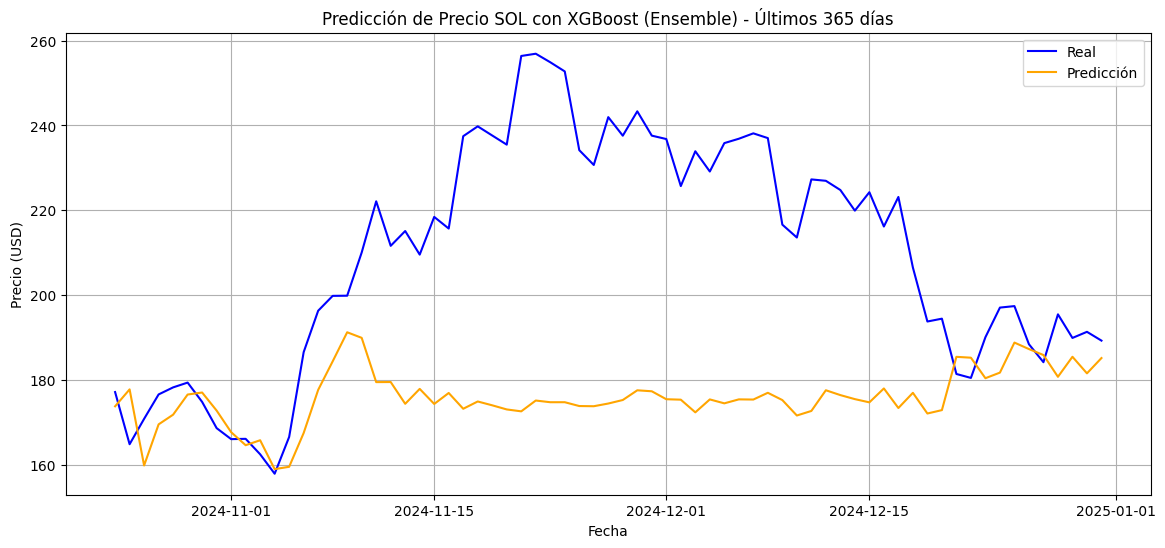

        Fecha  Predicción Precio SOL
0  2025-01-01             171.467743
1  2025-01-02             169.122192
2  2025-01-03             169.739471
3  2025-01-04             169.867813
4  2025-01-05             169.764435
5  2025-01-06             170.295883
6  2025-01-07             171.370056
7  2025-01-08             171.389618
8  2025-01-09             169.183304
9  2025-01-10             169.119507
10 2025-01-11             170.574753
11 2025-01-12             171.743134
12 2025-01-13             170.964447
13 2025-01-14             169.957001
14 2025-01-15             171.460266
15 2025-01-16             168.819733
16 2025-01-17             170.437241
17 2025-01-18             169.220062
18 2025-01-19             169.484787
19 2025-01-20             185.970886
20 2025-01-21             185.639420
21 2025-01-22             177.763626
22 2025-01-23             180.998032
23 2025-01-24             189.738190
24 2025-01-25             188.796463
25 2025-01-26             185.295212
2

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# ===============================
# 1. CARGAR Y PREPARAR LOS DATOS
# ===============================
df = pd.read_csv("SOLUSDT_1d_full.csv")

# Convertir fechas
df["Open Time"] = pd.to_datetime(df["Open Time"])
df["Close Time"] = pd.to_datetime(df["Close Time"])

# ===============================
# FILTRAR ÚLTIMOS 365 DÍAS
# ===============================
ultimo_dia = df["Open Time"].max()
inicio = ultimo_dia - pd.Timedelta(days=365)
df = df[df["Open Time"] >= inicio]

# Crear features
df['MA7'] = df['Close'].rolling(7).mean()
df['MA21'] = df['Close'].rolling(21).mean()
df['Return'] = df['Close'].pct_change()
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)

# Limpiar valores nulos
df = df.dropna()

# Variables de entrada y salida
X = df[['Open', 'High', 'Low', 'Volume', 'MA7', 'MA21', 'Return', 'Close_lag1', 'Close_lag2']]
y = df['Close'].shift(-1)
X = X[:-1]
y = y[:-1]

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ===============================
# 2. ENTRENAR MODELOS
# ===============================
m1 = XGBRegressor(n_estimators=600, learning_rate=0.03, max_depth=5, random_state=42, verbosity=0)
m1.fit(X_train, y_train, verbose=0)

m2 = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=3, random_state=7, verbosity=0)
m2.fit(X_train, y_train, verbose=0)

# ===============================
# 3. PREDICCIONES Y EVALUACIÓN
# ===============================
pred1 = m1.predict(X_test)
pred2 = m2.predict(X_test)
pred_final = (pred1 + pred2) / 2

mae = mean_absolute_error(y_test, pred_final)
r2 = r2_score(y_test, pred_final)

print(f"📊 MAE: {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# ===============================
# 4. VISUALIZACIÓN
# ===============================
plt.figure(figsize=(14,6))
plt.plot(df["Open Time"].iloc[-len(y_test):], y_test, label="Real", color="blue")
plt.plot(df["Open Time"].iloc[-len(y_test):], pred_final, label="Predicción", color="orange")
plt.legend()
plt.title("Predicción de Precio SOL con XGBoost (Ensemble) - Últimos 365 días")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.grid()
plt.show()

# ===============================
# 5. PREDICCIÓN FUTURA
# ===============================
ultimos_datos = X.tail(30)
predicciones_futuras = m1.predict(ultimos_datos)
fechas_futuras = pd.date_range(start=df["Open Time"].iloc[-1], periods=31, freq='D')[1:]
pred_df = pd.DataFrame({"Fecha": fechas_futuras, "Predicción Precio SOL": predicciones_futuras})

print(pred_df)


          ds           y
0 2024-09-04  127.582776
1 2024-09-05  133.568180
2 2024-09-06  129.273730
3 2024-09-07  124.887949
4 2024-09-08  127.687734
            ds           y
360 2025-08-30  205.083353
361 2025-08-31  202.710142
362 2025-09-01  200.900995
363 2025-09-02  196.883820
364 2025-09-03  209.230367


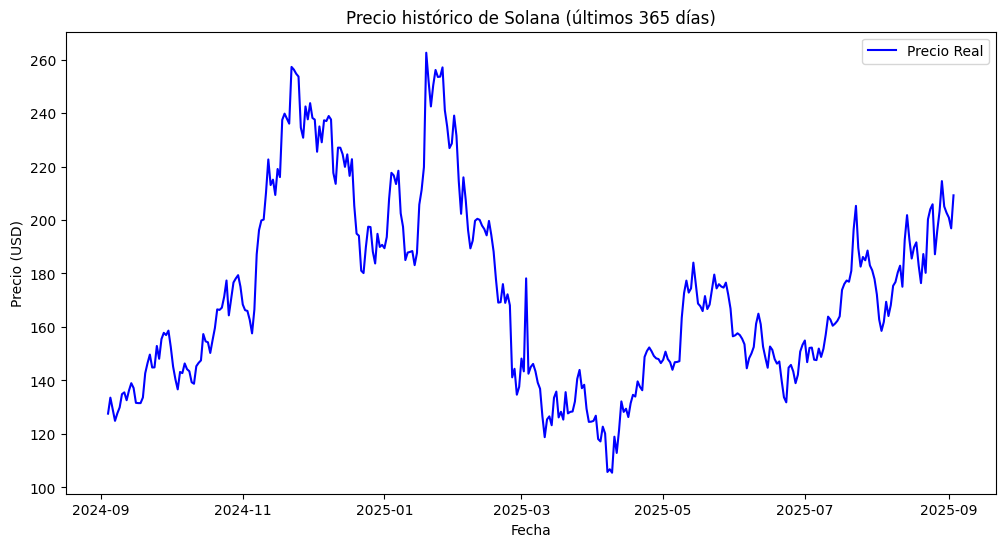

In [1]:
import pandas as pd

df = pd.read_csv('solana_last365.csv')
df['ds'] = pd.to_datetime(df['ds'])

print(df.head())   # Primeros 5 registros
print(df.tail())   # Últimos 5 registros

# Gráfica simple de precio histórico
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], label='Precio Real', color='blue')
plt.title('Precio histórico de Solana (últimos 365 días)')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()


In [12]:
print(df.head())
print(df.tail())
print(df.shape)



          ds           y
0 2024-09-04  127.582776
1 2024-09-05  133.568180
2 2024-09-06  129.273730
3 2024-09-07  124.887949
4 2024-09-08  127.687734
            ds           y
360 2025-08-30  205.083353
361 2025-08-31  202.710142
362 2025-09-01  200.900995
363 2025-09-02  196.883820
364 2025-09-03  209.230367
(365, 2)


In [14]:
import pandas as pd
from prophet import Prophet

# df debe tener columnas 'ds' y 'y'
df['ds'] = pd.to_datetime(df['ds'])


In [ ]:
#Crear y entrenar el modelo Prophet:
model = Prophet(daily_seasonality=True)
model.fit(df)


20:24:29 - cmdstanpy - INFO - Chain [1] start processing
20:24:29 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
#Generar fechas futuras (por ejemplo, 30 días desde hoy):

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

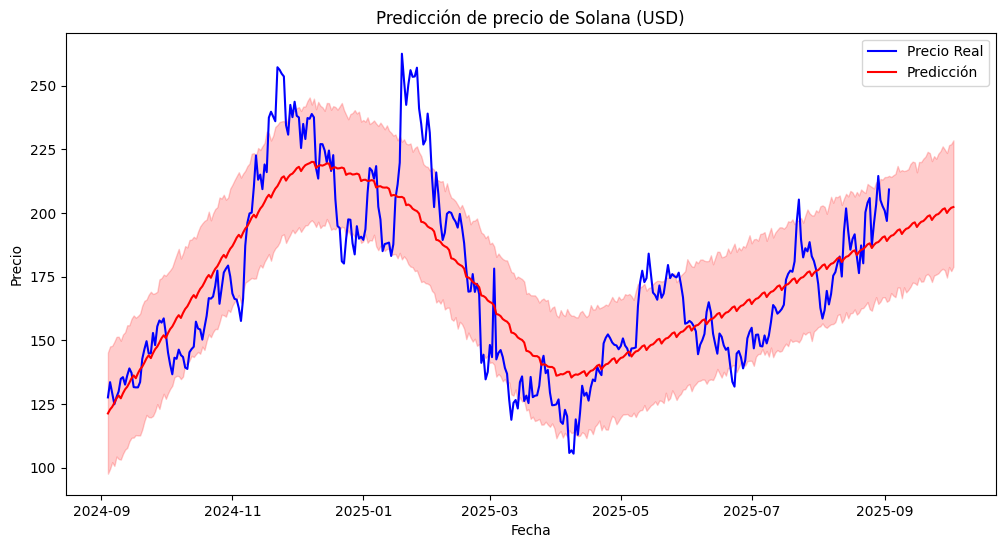

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], label='Precio Real', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicción', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)
plt.title('Predicción de precio de Solana (USD)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()


📊 MAE: 6.9480
📈 R² Score: 0.7870


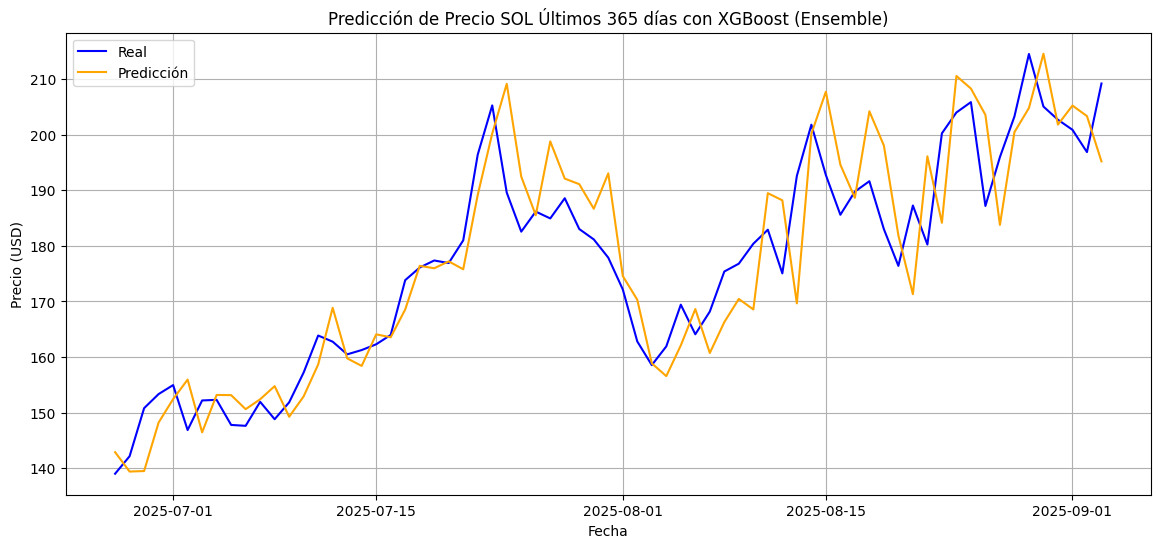

       Fecha  Predicción Precio SOL
0 2025-09-04             214.014847
1 2025-09-05             202.474319
2 2025-09-06             204.506973
3 2025-09-07             202.794235
4 2025-09-08             194.593414


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# ===============================
# 1. CARGAR Y PREPARAR LOS DATOS
# ===============================
df = pd.read_csv('solana_last365.csv')

# Asegúrate de que las fechas estén en datetime
df['ds'] = pd.to_datetime(df['ds'])

# Si tu CSV tiene columna "Close", úsala; si no, renombrar 'y' a 'Close'
if 'Close' not in df.columns and 'y' in df.columns:
    df.rename(columns={'y': 'Close'}, inplace=True)

# Crear features idénticos a tu script base
df['MA7'] = df['Close'].rolling(7).mean()
df['MA21'] = df['Close'].rolling(21).mean()
df['Return'] = df['Close'].pct_change()
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)

df = df.dropna()

X = df[['Close', 'MA7', 'MA21', 'Return', 'Close_lag1', 'Close_lag2']]
y = df['Close'].shift(-1)
X = X[:-1]
y = y[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ===============================
# 2. ENTRENAR MODELOS
# ===============================
m1 = XGBRegressor(n_estimators=600, learning_rate=0.03, max_depth=5, random_state=42, verbosity=0)
m1.fit(X_train, y_train, verbose=0)

m2 = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=3, random_state=7, verbosity=0)
m2.fit(X_train, y_train, verbose=0)

# ===============================
# 3. PREDICCIONES Y EVALUACIÓN
# ===============================
pred1 = m1.predict(X_test)
pred2 = m2.predict(X_test)

pred_final = (pred1 + pred2) / 2

mae = mean_absolute_error(y_test, pred_final)
r2 = r2_score(y_test, pred_final)

print(f"📊 MAE: {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# ===============================
# 4. VISUALIZACIÓN
# ===============================
plt.figure(figsize=(14,6))
plt.plot(df['ds'].iloc[-len(y_test):], y_test, label='Real', color='blue')
plt.plot(df['ds'].iloc[-len(y_test):], pred_final, label='Predicción', color='orange')
plt.legend()
plt.title("Predicción de Precio SOL Últimos 365 días con XGBoost (Ensemble)")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.grid()
plt.show()

# ===============================
# 5. PREDICCIÓN FUTURA
# ===============================
ultimos_datos = X.tail(5)  # Predicción a 5 días
predicciones_futuras = m1.predict(ultimos_datos)
fechas_futuras = pd.date_range(start=df['ds'].iloc[-1], periods=6, freq='D')[1:]
pred_df = pd.DataFrame({"Fecha": fechas_futuras, "Predicción Precio SOL": predicciones_futuras})

print(pred_df)


20:59:23 - cmdstanpy - INFO - Chain [1] start processing
20:59:23 - cmdstanpy - INFO - Chain [1] done processing


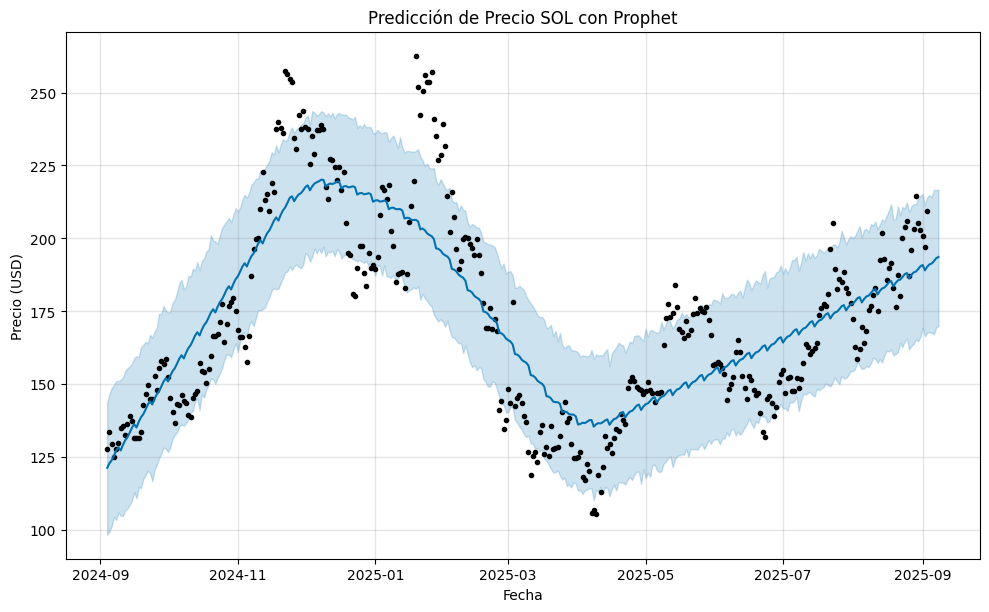

            ds        yhat  yhat_lower  yhat_upper
365 2025-09-04  191.047750  167.736406  214.798857
366 2025-09-05  191.339683  167.639037  214.095520
367 2025-09-06  192.182410  167.074786  216.649060
368 2025-09-07  193.174194  169.421974  216.511669
369 2025-09-08  193.592996  169.918324  216.714508


In [41]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# ===============================
# 1. CARGAR Y PREPARAR LOS DATOS
# ===============================
df = pd.read_csv('solana_last365.csv')

# Asegúrate de que las fechas estén en datetime
df['ds'] = pd.to_datetime(df['ds'])

# Si tu CSV tiene columna 'y', úsala; si tiene 'Close', renombrar
if 'y' not in df.columns and 'Close' in df.columns:
    df.rename(columns={'Close': 'y'}, inplace=True)

# ===============================
# 2. CREAR Y ENTRENAR EL MODELO
# ===============================
model = Prophet(daily_seasonality=True)
model.fit(df)

# ===============================
# 3. PREDICCIONES FUTURAS
# ===============================
future = model.make_future_dataframe(periods=5)  # Predecir 5 días hacia adelante
forecast = model.predict(future)

# ===============================
# 4. VISUALIZACIÓN
# ===============================
fig1 = model.plot(forecast)
plt.title("Predicción de Precio SOL con Prophet")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.show()

# ===============================
# 5. EXTRACCIÓN DE PREDICCIONES FUTURAS
# ===============================
predicciones_futuras = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)
print(predicciones_futuras)


In [45]:
import pandas as pd
import numpy as np
import requests
import time
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# ===============================
# 1. DESCARGAR DATOS DESDE COINGECKO
# ===============================
max_retries = 5
for i in range(max_retries):
    try:
        url = "https://api.coingecko.com/api/v3/coins/solana/market_chart"
        params = {"vs_currency": "usd", "days": "365", "interval": "daily"}
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        break
    except (requests.ConnectionError, requests.Timeout, requests.HTTPError) as e:
        print(f"Intento {i+1} fallido: {e}")
        time.sleep(2)
else:
    raise Exception("No se pudo descargar el dataset de CoinGecko después de varios intentos.")

# Convertir a DataFrame
df = pd.DataFrame(data['prices'], columns=['timestamp', 'close'])
df['ds'] = pd.to_datetime(df['timestamp'], unit='ms')
df['y'] = df['close']

# ===============================
# 2. CREAR FEATURES
# ===============================
df['MA7'] = df['y'].rolling(7).mean()
df['MA21'] = df['y'].rolling(21).mean()
df['Return'] = df['y'].pct_change()
df['Close_lag1'] = df['y'].shift(1)
df['Close_lag2'] = df['y'].shift(2)
df = df.dropna()

X = df[['y', 'MA7', 'MA21', 'Return', 'Close_lag1', 'Close_lag2']]
y = df['y'].shift(-1)
X = X[:-1]
y = y[:-1]

# ===============================
# 3. ENTRENAR MODELO
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# ===============================
# 4. PREDICCIÓN SIGUIENTE DÍA
# ===============================
ultimo_dato = X.tail(1)
precio_estimado = model.predict(ultimo_dato)[0]
precio_actual = df['y'].iloc[-1]
direccion = "Subirá ⬆️" if precio_estimado > precio_actual else "Bajará ⬇️"
fecha_ultimo = df['ds'].iloc[-1]

print(f"Fecha del último precio: {fecha_ultimo.date()}")
print(f"Precio actual: ${precio_actual:.2f}")
print(f"Precio estimado siguiente día: ${precio_estimado:.2f} → {direccion}")




Fecha del último precio: 2025-09-15
Precio actual: $234.38
Precio estimado siguiente día: $251.52 → Subirá ⬆️


In [49]:
import pandas as pd
import numpy as np
from pycoingecko import CoinGeckoAPI
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# ===============================
# 1. DESCARGAR DATOS DE COINGECKO
# ===============================
cg = CoinGeckoAPI()

# Obtenemos los últimos 365 días de precios diarios
data = cg.get_coin_market_chart_by_id(
    id='solana',
    vs_currency='usd',
    days=365,
    interval='daily'
)

# Precios (timestamp en ms, precio)
prices = data['prices']
df = pd.DataFrame(prices, columns=['timestamp', 'price'])
df['ds'] = pd.to_datetime(df['timestamp'], unit='ms').dt.normalize()  # tomar solo fecha
df = df.groupby('ds').last().reset_index()  # 1 precio por día
df = df.rename(columns={'price': 'Close'})

# ===============================
# 2. CREAR FEATURES
# ===============================
df['MA7'] = df['Close'].rolling(7).mean()
df['MA21'] = df['Close'].rolling(21).mean()
df['Return'] = df['Close'].pct_change()
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)
df = df.dropna()

# Variables X y y
X = df[['Close', 'MA7', 'MA21', 'Return', 'Close_lag1', 'Close_lag2']]
y = df['Close'].shift(-1)[:-1]  # predecir siguiente día
X = X[:-1]

# ===============================
# 3. ENTRENAR MODELO
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=5,
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# ===============================
# 4. PREDICCIÓN SIGUIENTE DÍA
# ===============================
ultimo_dato = X.tail(1)
pred_siguiente = model.predict(ultimo_dato)[0]

ultimo_precio = df['Close'].iloc[-1]
fecha_ultimo = df['ds'].iloc[-1]

print(f"Fecha del último precio: {fecha_ultimo.date()}")
print(f"Precio actual: ${ultimo_precio:.2f}")
print(f"Precio estimado siguiente día: ${pred_siguiente:.2f} → {'Subirá ↑' if pred_siguiente > ultimo_precio else 'Bajará ↓'}")



Fecha del último precio: 2025-09-15
Precio actual: $234.79
Precio estimado siguiente día: $249.93 → Subirá ↑


In [4]:
import requests
import pandas as pd
import time

# Parámetros
symbol = "SOLUSDT"
interval = "1h"
limit = 1000  # máximo por petición
total_hours = 5000  # queremos mínimo 5000 horas
base_url = "https://api.binance.com/api/v3/klines"

all_data = []
end_time = int(time.time() * 1000)  # tiempo actual en ms
hours_remaining = total_hours

print(f"📥 Descargando {total_hours} horas de datos de {symbol}...")

while hours_remaining > 0:
    fetch_limit = min(limit, hours_remaining)
    params = {
        "symbol": symbol,
        "interval": interval,
        "endTime": end_time,
        "limit": fetch_limit
    }
    
    response = requests.get(base_url, params=params)
    try:
        data = response.json()
    except Exception as e:
        print(f"❌ Error al procesar la respuesta: {e}")
        break

    if not isinstance(data, list) or len(data) == 0:
        print("⏹️ No hay más datos disponibles.")
        break

    all_data.extend(data)
    end_time = data[0][0] - 1  # retrocedemos en el tiempo
    hours_remaining -= len(data)
    print(f"⏳ Restan {hours_remaining} horas por descargar...")

# Crear DataFrame
df = pd.DataFrame(all_data, columns=[
    "timestamp", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "trades",
    "taker_buy_base", "taker_buy_quote", "ignore"
])

# Convertir tipos
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
numeric_cols = ["open", "high", "low", "close", "volume"]
df[numeric_cols] = df[numeric_cols].astype(float)

# Guardar CSV
df.to_csv("solana_5000h.csv", index=False)
print(f"✅ Dataset guardado como solana_5000h.csv con {len(df)} filas.")


📥 Descargando 5000 horas de datos de SOLUSDT...
⏹️ No hay más datos disponibles.
✅ Dataset guardado como solana_5000h.csv con 0 filas.
